## A closer look at QMCPy's Sobol' generator

In [1]:
from qmcpy import Sobol
from numpy import *
from matplotlib import pyplot
from time import time
import os

### Basic usage

In [2]:
s = Sobol(5,seed=7)
s

Sobol (DiscreteDistribution Object)
    dimension       5
    randomize       1
    graycode        0
    seed            [ 327741615  976413892 3349725721 1369975286 1882953283]
    mimics          StdUniform
    dim0            0

In [3]:
s.gen_samples(4)

array([[0.305, 0.74 , 0.462, 0.676, 0.558],
       [0.814, 0.497, 0.839, 0.116, 0.159],
       [0.217, 0.172, 0.686, 0.422, 0.861],
       [0.663, 0.913, 0.06 , 0.857, 0.48 ]])

In [4]:
s.gen_samples(n_min=2,n_max=4) # generate from specific range. If range is not powers of 2, use graycode

array([[0.217, 0.172, 0.686, 0.422, 0.861],
       [0.663, 0.913, 0.06 , 0.857, 0.48 ]])

In [5]:
t0 = time()
s.gen_samples(2**25)
print('Time: %.2f'%(time()-t0))

Time: 1.07


### Randomize with digital shift / linear matrix scramble

In [6]:
s = Sobol(2,randomize='LMS') # linear matrix scramble (default) (includes digital shift)
s.gen_samples(2)

array([[0.67 , 0.246],
       [0.163, 0.583]])

In [7]:
s.set_randomize('DS') # just a digital shift
s.gen_samples(2)

array([[0.01 , 0.213],
       [0.51 , 0.713]])

### Support for graycode and natural ordering

In [8]:
s = Sobol(2,randomize=False,graycode=False)
s.gen_samples(n_min=4,n_max=8,warn=False) # don't warn about non-randomized samples including the orgin

array([[0.125, 0.625],
       [0.625, 0.125],
       [0.375, 0.375],
       [0.875, 0.875]])

In [9]:
s.set_graycode(True)
s.gen_samples(n_min=4,n_max=8,warn=False)

array([[0.375, 0.375],
       [0.875, 0.875],
       [0.625, 0.125],
       [0.125, 0.625]])

## Seeding and skipping dimensions

In [10]:
s = Sobol(3,graycode=True,seed=7) # set a single seed
s.gen_samples(2)

array([[0.305, 0.74 , 0.462],
       [0.814, 0.497, 0.839]])

In [11]:
s.set_seed([7,11,17]) # set a seed for each dimension
s.gen_samples(2)

array([[0.231, 0.791, 0.131],
       [0.871, 0.39 , 0.85 ]])

In [12]:
s.set_dimension(4) # adding another dimension will give 1 new random seed
print(s.gen_samples(2))
print(s)

[[0.231 0.791 0.131 0.676]
 [0.871 0.39  0.85  0.116]]
Sobol (DiscreteDistribution Object)
    dimension       2^(2)
    randomize       1
    graycode        1
    seed            [         7         11         17 1369975286]
    mimics          StdUniform
    dim0            0


In [13]:
s.set_dimension(2) # deleting dimensions will cut out the later seeds
print(s.gen_samples(2))
print(s)

[[0.231 0.791]
 [0.871 0.39 ]]
Sobol (DiscreteDistribution Object)
    dimension       2^(1)
    randomize       1
    graycode        1
    seed            [ 7 11]
    mimics          StdUniform
    dim0            0


In [14]:
# be careful, skipping dimensions does not skip seeds
s.set_dim0(1)
s.set_seed([11,17])
print(s.gen_samples(2))
s

[[0.791 0.131]
 [0.39  0.85 ]]


Sobol (DiscreteDistribution Object)
    dimension       2^(1)
    randomize       1
    graycode        1
    seed            [11 17]
    mimics          StdUniform
    dim0            1

### Custom generating matricies

In [15]:
# a previously created generating matrix (not the default)
z = load('../qmcpy/discrete_distribution/sobol/generating_matricies/gen_mat.51.30.msb.npy')
# max dimension 51, max samples 2^30, most significant bit in top of column
print(z.dtype)
z[:2,:2]

int64


array([[536870912, 805306368],
       [536870912, 268435456]])

In [20]:
z_custom = z[:10,:] # say this is our custom generating matrix
d_max,m_max = z_custom.shape
f_path = 'my_sobol_mat.%d.%d.msb.npy'%(d_max,m_max)
save(f_path, z_custom)# save it to a file with proper naming convention

In [21]:
s = Sobol(3,z_path=f_path) # plug in the path
s.gen_samples(4)
os.remove(f_path)

# Elementay intervals

In [18]:
def plt_ei(x,ax,x_cuts,y_cuts):
    ax.scatter(x[:,0],x[:,1],color='b',s=10)
    for ix in arange(1,x_cuts,dtype=float): ax.axvline(x=ix/x_cuts,color='r')
    for iy in arange(1,y_cuts,dtype=float): ax.axhline(y=iy/y_cuts,color='r')
    ax.set_xlim([0,1])
    ax.set_xticks([0,1])
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    ax.set_aspect(1)

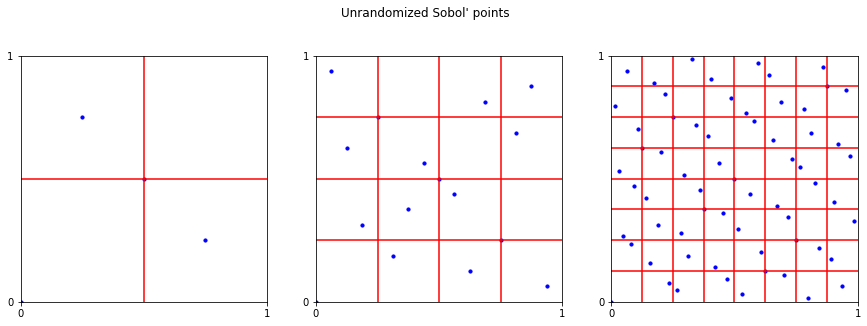

In [19]:
# unrandomized 
fig,ax = pyplot.subplots(ncols=3,nrows=1,figsize=(15,5))
s = Sobol(2,randomize=False)
plt_ei(s.gen_samples(2**2,warn=False),ax[0],2,2)
plt_ei(s.gen_samples(2**4,warn=False),ax[1],4,4)
plt_ei(s.gen_samples(2**6,warn=False),ax[2],8,8)
fig.suptitle("Unrandomized Sobol' points");

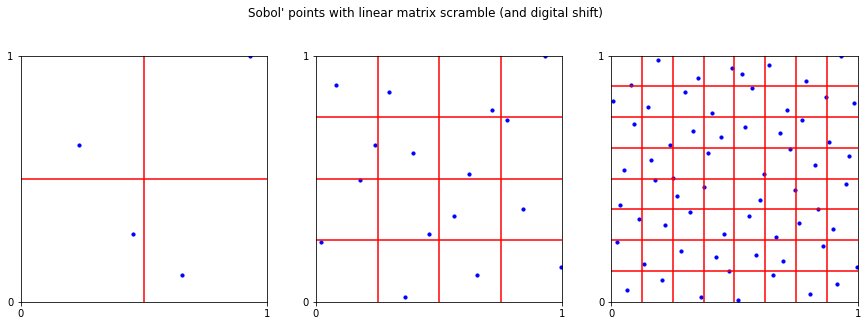

In [20]:
fig,ax = pyplot.subplots(ncols=3,nrows=1,figsize=(15,5))
s = Sobol(2,randomize='LMS')
plt_ei(s.gen_samples(2**2,warn=False),ax[0],2,2)
plt_ei(s.gen_samples(2**4,warn=False),ax[1],4,4)
plt_ei(s.gen_samples(2**6,warn=False),ax[2],8,8)
fig.suptitle("Sobol' points with linear matrix scramble (and digital shift)");

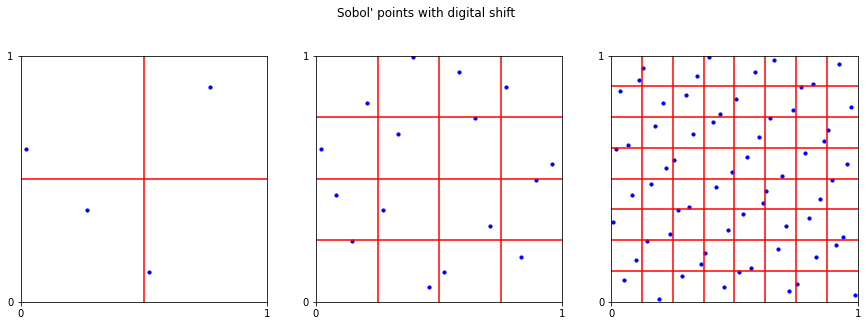

In [21]:
fig,ax = pyplot.subplots(ncols=3,nrows=1,figsize=(15,5))
s = Sobol(2,randomize='DS')
plt_ei(s.gen_samples(2**2),ax[0],2,2)
plt_ei(s.gen_samples(2**4),ax[1],4,4)
plt_ei(s.gen_samples(2**6),ax[2],8,8)
fig.suptitle("Sobol' points with digital shift");

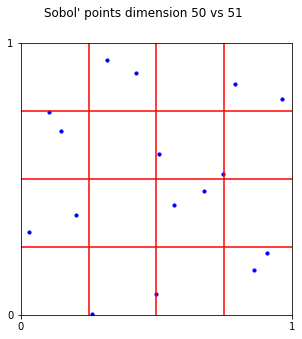

In [22]:
fig,ax = pyplot.subplots(figsize=(15,5))
s = Sobol(2,randomize='LMS',dim0=50)
plt_ei(s.gen_samples(2**4),ax,4,4)
fig.suptitle("Sobol' points dimension 50 vs 51");
# nice properties do not necessary hold in higher dimensions